In [14]:
import torch
from torch import nn
from torchsummary import summary
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
DATA_PATH = './data'
BATCH_SIZE = 128
EPOCH_NUM = 100
LR = 2e-4

In [17]:
dataset = dset.FashionMNIST(root="./data", download=True,
                     transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2, drop_last=True)

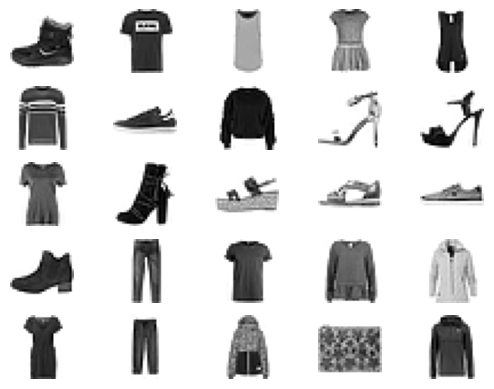

In [18]:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis("off")
    plt.imshow(dataset.__getitem__(i)[0].reshape(28, 28), cmap="gray_r")
plt.show()

In [19]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv')!=-1 or classname.find('Linear')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('BatchNorm')!=-1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)

In [20]:
class Discriminator(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 2, padding=1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        #leakyReLU
        #dropout
        self.conv3 = nn.Conv2d(64, 128, 3, 2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        #LeakyReLU
        #dropout
        self.conv4 = nn.Conv2d(128, 256, 3, padding='same')
        self.bn3 = nn.BatchNorm2d(256)
        #LeakyReLU
        #dropout
        self.flatten = nn.Flatten()
        
        self.ll1 = nn.LazyLinear(1)
        self.sigmoid = nn.Sigmoid()
        
        self.ll2 = nn.LazyLinear(n_classes)
        self.softmax = nn.Softmax()
    
    def forward(self, x):
        x = self.dropout(self.lrelu(self.conv1(x)))
        x = self.dropout(self.lrelu(self.bn1(self.conv2(x))))
        x = self.dropout(self.lrelu(self.bn2(self.conv3(x))))
        x = self.dropout(self.lrelu(self.bn3(self.conv4(x))))
        x = self.flatten(x)
        out = self.sigmoid(self.ll1(x))
        c_out = self.softmax(self.ll2(x))
        return out, c_out

In [21]:
netD = Discriminator(10).to(device)
netD.apply(weights_init)

criterion_D = nn.BCELoss()
criterion_Q = nn.CrossEntropyLoss()

summary(netD, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
         LeakyReLU-2           [-1, 32, 14, 14]               0
           Dropout-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
       BatchNorm2d-5           [-1, 64, 14, 14]             128
         LeakyReLU-6           [-1, 64, 14, 14]               0
           Dropout-7           [-1, 64, 14, 14]               0
            Conv2d-8            [-1, 128, 7, 7]          73,856
       BatchNorm2d-9            [-1, 128, 7, 7]             256
        LeakyReLU-10            [-1, 128, 7, 7]               0
          Dropout-11            [-1, 128, 7, 7]               0
           Conv2d-12            [-1, 256, 7, 7]         295,168
      BatchNorm2d-13            [-1, 256, 7, 7]             512
        LeakyReLU-14            [-1, 25

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [22]:
class Generator(nn.Module):
    def __init__(self, n_classes):
        super(Generator, self).__init__()
        
        self.embedding = nn.Embedding(n_classes, 50)
        self.ll1 = nn.Linear(50, 7**2)
        
        self.ll2 = nn.Linear(100, 384*7*7)
        self.relu = nn.ReLU()
        
        self.convt1 = nn.ConvTranspose2d(385, 192, 5, 2, padding=2, output_padding=1)
        self.bn1 = nn.BatchNorm2d(192)
        #ReLU
        self.convt2 = nn.ConvTranspose2d(192, 1, 5, 2, padding=2, output_padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x, input_class=torch.Tensor([1, 1]).to(device, dtype=int)):
        input_class = self.embedding(input_class)
        input_class = self.ll1(input_class)
        input_class = input_class.view(-1, 1, 7, 7)
        
        x = self.relu(self.ll2(x))
        x = x.view(-1, 384, 7, 7)
        
        out = torch.concatenate((x, input_class), dim=1)
        out = self.relu(self.bn1(self.convt1(out)))
        out = self.tanh(self.convt2(out))
        return out

In [23]:
netG = Generator(10).to(device)
netG.apply(weights_init)

criterion_G = nn.BCELoss()

summary(netG, (1, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                   [-1, 50]             500
            Linear-2                   [-1, 49]           2,499
            Linear-3             [-1, 1, 18816]       1,900,416
              ReLU-4             [-1, 1, 18816]               0
   ConvTranspose2d-5          [-1, 192, 14, 14]       1,848,192
       BatchNorm2d-6          [-1, 192, 14, 14]             384
              ReLU-7          [-1, 192, 14, 14]               0
   ConvTranspose2d-8            [-1, 1, 28, 28]           4,801
              Tanh-9            [-1, 1, 28, 28]               0
Total params: 3,756,792
Trainable params: 3,756,792
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.16
Params size (MB): 14.33
Estimated Total Size (MB): 15.49
-------------------------------------

In [24]:
G_optimizer = optim.Adam(netG.parameters(), lr=1e-3, betas=(0.5,0.999))
D_optimizer = optim.Adam(netD.parameters(), lr=LR, betas=(0.5,0.999))

In [25]:
import os
import numpy as np

def save_image(img_list, epoch):
    plt.figure(figsize=(16, 16));
    plt.axis("off")
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    if not os.path.exists('generated'):
        os.makedirs('generated')
    plt.savefig("generated/img%d.png" % epoch, bbox_inches='tight', pad_inches=0)  

In [ ]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

img_list = []

viz_noise = torch.randn(BATCH_SIZE, 1, 1, 100, device=device)
viz_classes = torch.randint(0, 10, (BATCH_SIZE,), device=device)

now = datetime.now()
timestamp = now.strftime("%Y%m%d-%H%M%S")
logdir = f"trainings/{timestamp}/"
writer = SummaryWriter(logdir)
global_step = 0

for ep in range(EPOCH_NUM):
  torch.cuda.empty_cache()
  batch_iterator = tqdm(dataloader, desc=f"Processing Epoch {ep+1:02d}")
  for i, (data, labels) in enumerate(batch_iterator):
    b_size = data.shape[0]

    data = data.to(device)
    real_labels = torch.ones((b_size, 1), requires_grad=False).to(device)
    fake_labels = torch.zeros((b_size, 1), requires_grad=False).to(device)

    netD.zero_grad()

    real_d, d_classes = netD(data)
    loss_D_real = criterion_D(real_d, real_labels)
    loss_D_real_classes = criterion_Q(d_classes, labels.to(device))
    
    z_var = torch.randn(b_size, 1, 1, 100, device=device)
    z_classes = torch.randint(0, 10, (b_size,), device=device)
    fake_images = netG(z_var, z_classes)
    fake_d, d_classes = netD(fake_images.detach())
    loss_D_fake = criterion_D(fake_d, fake_labels)
    loss_D_fake_classes = criterion_Q(d_classes, z_classes)

    loss_D = (loss_D_real + loss_D_real_classes + loss_D_fake + loss_D_fake_classes) / 4
    loss_D.backward(retain_graph=True)

    netG.zero_grad()
    criterion_Q.zero_grad()
    
    fake_d, fake_classification = netD(fake_images)

    loss_G = criterion_D(fake_d, real_labels)
    loss_G_classes = criterion_Q(fake_classification, z_classes)
    loss_G = loss_G + loss_G_classes
    loss_G.backward(retain_graph=True)
    loss_Q = (loss_D_real_classes + loss_D_fake_classes)/2
    loss_Q.backward()
    
    D_optimizer.step()
    G_optimizer.step()
    
    writer.add_scalars('losses', {'DLoss': loss_D.item(), 'GLoss': loss_G.item(), 'QLoss': loss_Q.item()}, global_step)
    writer.flush()
    global_step += 1
    if (i % 500 == 0) or ((ep == EPOCH_NUM-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
        fake = netG(viz_noise, viz_classes).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
  if ep % 2 == 0:
    save_image(img_list, ep+1)

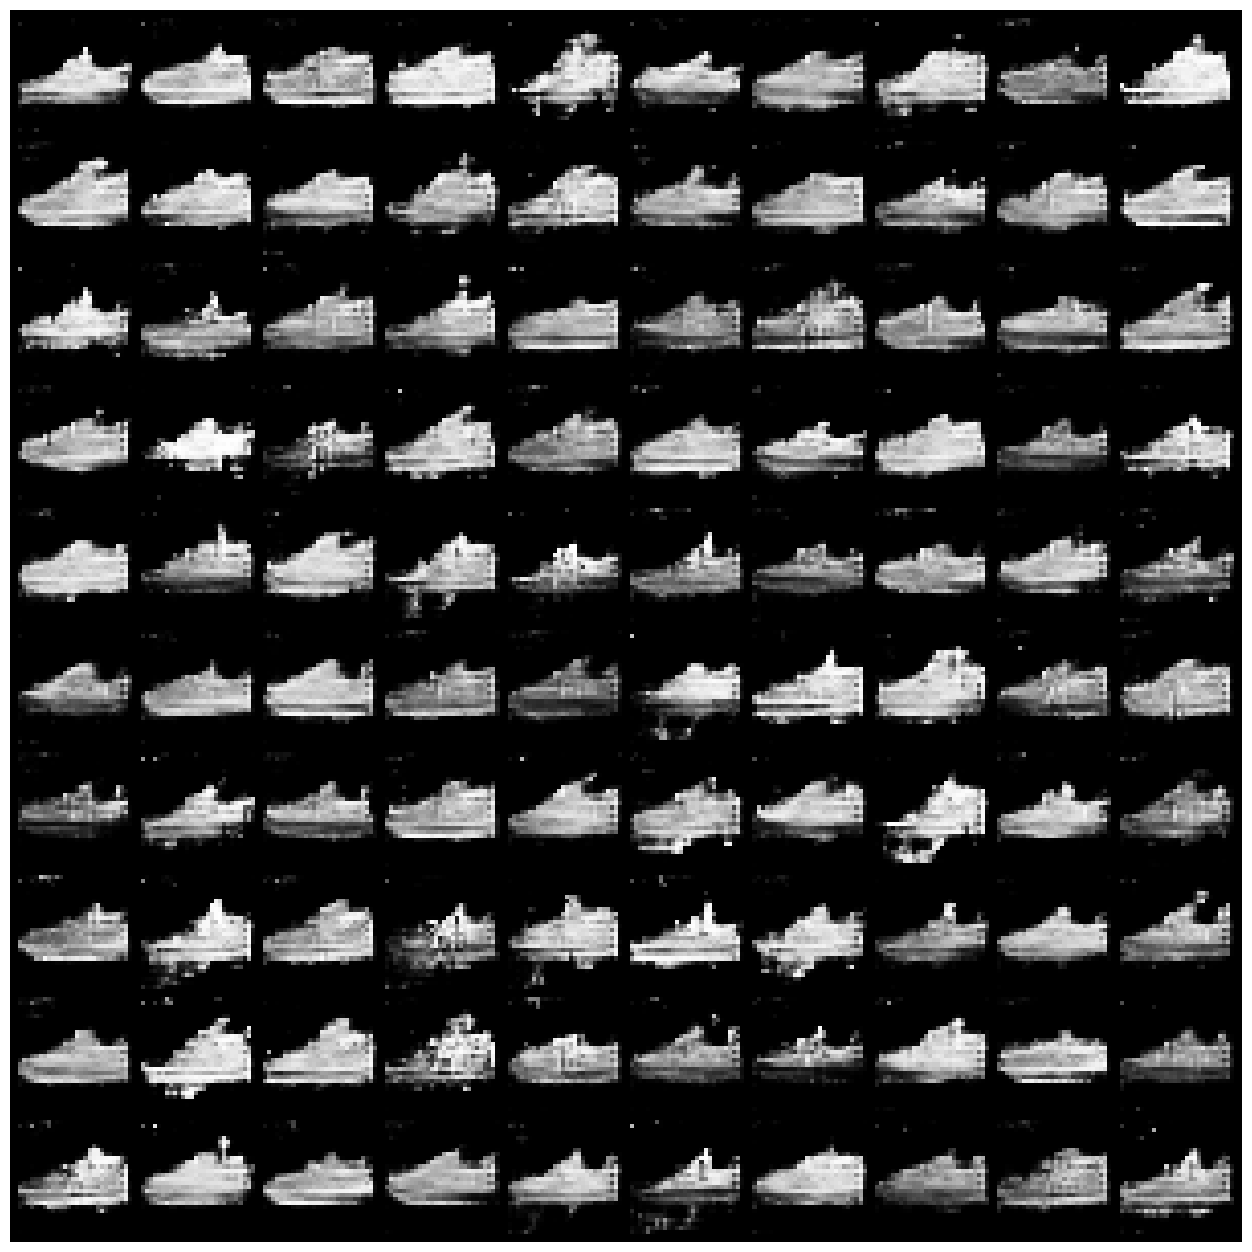

In [32]:
t_img_list = []
z_var = torch.randn(100, 1, 1, 100, device=device)
z_classes = torch.full((100,), 7).to(device)
with torch.no_grad():
    fake = netG(z_var, z_classes).detach().cpu()
    t_img_list.append(vutils.make_grid(fake, padding=2, normalize=True, nrow=10))
save_image(t_img_list, 777)